# **Sentiment Analysis for Investiment Strategies on Tesla Stock**
# 3. News Classification with Fine-tuning Flan-T5
In the previous step, we tried in-context learning for Flan-T5 to classify if a news article is directly related to Tesla or not.

In this notebook, parameter efficient fine-tuning (PEFT) is tested on Flan-T5 for the same task. Low-Rank adaptation of LLM (LoRA) method was chosed to reduce fine-tuning cost. You can learn more about LoRA [here](https://medium.com/data-science-in-your-pocket/lora-for-fine-tuning-llms-explained-with-codes-and-example-62a7ac5a3578).

LoRA basics:
* A reparameter technique.
* Freeze most of the original LLM weights.
* Inject 2 rank decomposiiton matrices, A and B in the figure.
* Train only the weights of the smaller matrices A and B.

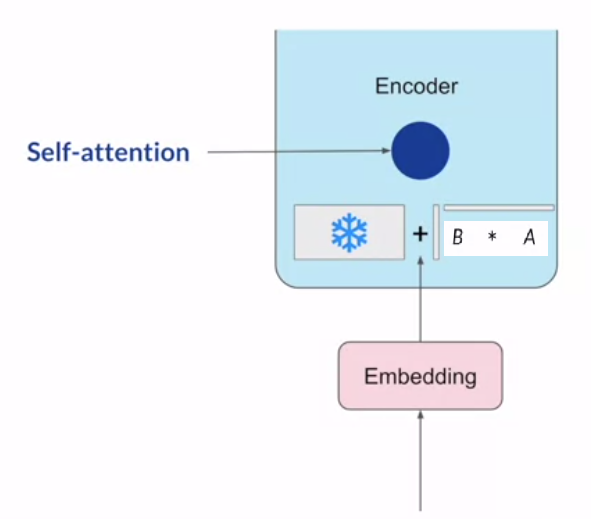

In [1]:
# check for GPU
!nvidia-smi

Mon Nov 27 16:39:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# install the required libraries
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 7.9 MB/s eta 0:00:00


In [57]:
import pandas as pd
import numpy as np
import time

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrainingArguments, Trainer, GenerationConfig
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig

In [4]:
# calculate number of model parameters and trainable parameters
def print_number_of_trainable_model_parameters(model):
  trainables = 0
  all = 0
  for _,param in model.named_parameters():
    all += param.numel()
    if param.requires_grad:
      trainables += param.numel()
  return f"Trainable model paramters: {trainables}\nAll model paramters: {all}\nPercentage of trainables: {trainables/all*100:.2f} %"

In [5]:
# convert text to a prompt for classification task
def create_prompt(news):
  return f"""
  Classify if the following news paragraph is directly related to Tesla or not.\n\n
      {news}\n\n
  Is the news directly related to Tesla?
  """


In [6]:
# modify the true labels
def create_labels(x):
  if x == "yes":
    return "Yes, it is directly related to Tesla."
  else:
    return "No, it is not directly related to Tesla"

## 3.1. Data Preparation

In [7]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Tesla_News_Sentiment_Analysis_Tests/data/Tesla_news_manual_labels.csv'
datadf = pd.read_csv(data_path, encoding = 'latin1', index_col = 0)
datadf.head()

,source_name,author,date,title,description,content,label,tesla_related
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,yes
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,yes
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,no
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,no
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,yes


In [8]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 206
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   source_name    207 non-null    object
 1   author         207 non-null    object
 2   date           207 non-null    object
 3   title          207 non-null    object
 4   description    207 non-null    object
 5   content        207 non-null    object
 6   label          207 non-null    object
 7   tesla_related  207 non-null    object
dtypes: object(8)
memory usage: 14.6+ KB


In [9]:
# check distribution of news classification
datadf.tesla_related.value_counts()

yes    116
no      91
Name: tesla_related, dtype: int64

In [10]:
# check distribution of sentiments
datadf.label.value_counts()

neutral     84
negative    63
positive    59
neagtive     1
Name: label, dtype: int64

In [11]:
# correct the manual typo
datadf['label'] = datadf['label'].replace('neagtive', 'negative')
datadf.label.value_counts()

neutral     84
negative    64
positive    59
Name: label, dtype: int64

In [12]:
# create an additional col of title+description
datadf['title_desc'] = datadf['title'].map(str) + ' ' + datadf['description'].map(str)
datadf.head()

,source_name,author,date,title,description,content,label,tesla_related,title_desc
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,yes,How Elon Musk lost a friend over AI: Google co...
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,yes,Bill Gates Tries to Profit by Driving Down Tes...
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,no,Putin hails Elon Musk as an 'outstanding perso...
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,no,"What do donkeys, dragons and Hawaii have in co..."
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,yes,Elon Musks supercomputer Dojo added $70 billi...


In [13]:
# create the prompt wrapper and modify true labels
datadf['prompt'] = datadf['title_desc'].apply(create_prompt)
datadf['manual_baseline'] = datadf['tesla_related'].apply(create_labels)
print(datadf.loc[100, 'prompt'])
print("-"*100)
print(datadf.loc[100, 'manual_baseline'])


  Classify if the following news paragraph is directly related to Tesla or not.


      Jaguar jettisions CCS charger plug, negotiates Tesla Supercharger access Jaguars will sport native North American Charging Standard plugs from 2025.


  Is the news directly related to Tesla?
  
----------------------------------------------------------------------------------------------------
Yes, it is directly related to Tesla.


## 3.2. Load Model and Tokenizer

In [101]:
model_name = 'google/flan-t5-base'
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [15]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

## 3.3. Zero-Shot Test

In [16]:
indexts = 10
inputs = tokenizer(datadf.loc[indexts, 'prompt'], return_tensors = 'pt')
outputs = tokenizer.decode(
    original_model.generate(
        inputs['input_ids'],
        max_new_tokens = 200
    )[0],
    skip_special_tokens = True
)

In [17]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask'])

In [18]:
inputs['input_ids']

tensor([[ 4501,  4921,     3,    99,     8,   826,  1506,  8986,    19,  1461,
          1341,    12, 19939,    42,    59,     5,  9014,     3,    31, 10991,
           106, 23763,    31,    10,  7462,    25,   174,    12,   214,    81,
             8, 13171, 20876,   739, 25705,  1029,  3079,    28, 24462,   216,
           986,    11, 23427,    15,     7,     6,     3,    31,  1778,   106,
          2175,    31,    11,  2042,  4907,     6,     3,    31, 10991,   106,
         23763,    31,   704,    46, 11050,   320,  1096,     8,  2581,  2108,
          2378,    31,     7,   280,     5,    27,     7,     8,  1506,  1461,
          1341,    12, 19939,    58,     3,     1]])

In [19]:
inputs['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [20]:
outputs

'Yes'

In [21]:
print(datadf.loc[indexts,'prompt'])


  Classify if the following news paragraph is directly related to Tesla or not.


      Inside 'Elon Musk': Everything you need to know about the Walter Isaacson biography From relationships with Amber Heard and Grimes, 'demon mode' and Starlink, 'Elon Musk' offers an intimate look inside the famous billionaire's life.


  Is the news directly related to Tesla?
  


In [22]:
print(datadf.loc[indexts,'manual_baseline'])

No, it is not directly related to Tesla


## 3.4. Create Pytorch Dataset
In order to train Flan-T5 model, the input data need to be prepared in Pytorch way.

Use `torch.utils.data.Dataset` class to store samples for modeling.

In [23]:
# create a pytorch dataset class
class Tokenized_Dataset(Dataset):
    # initialze the pytorch dataset object with input parameters
    def __init__(self, prompts, baselines, tokenizer):
        self.news = prompts
        self.labels = baselines
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length # use the max length supported by BERT model which is 512
    # returns the number of samples
    def __len__(self):
        return len(self.news)
    # loads and returns a sample from the dataset at a given index
    def __getitem__(self, index):
        content = str(self.news[index])
        label = str(self.labels[index])
        # encode the news using the input tokenizer
        encoded_news = self.tokenizer.encode_plus(
            content,
            add_special_tokens    = True,
            max_length            = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors        = "pt",
            padding               = "max_length",
            truncation            = True
        )
        # encode the manual labels using the input tokenizer
        encoded_labels = self.tokenizer.encode_plus(
            label,
            add_special_tokens    = True,
            max_length            = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors        = "pt",
            padding               = "max_length",
            truncation            = True
        )
        # output the input_id, the attention_mask and the corresponding label in input
        return {
            'input_ids': encoded_news['input_ids'][0],
            'attention_mask': encoded_news['attention_mask'][0],
            'labels': encoded_labels['input_ids'][0]
        }

## 3.5. Train / Validation Split

In [24]:
# randomize the data before splitting
cols = ['prompt', 'manual_baseline']
df_train = datadf[cols].sample(n = int(datadf.shape[0]*0.7), random_state = 42)
df_train['manual_baseline'].value_counts()

Yes, it is directly related to Tesla.      82
No, it is not directly related to Tesla    62
Name: manual_baseline, dtype: int64

In [25]:
# create itermediate validataion data
df_val = datadf[cols].drop(df_train.index)
df_val['manual_baseline'].value_counts()

Yes, it is directly related to Tesla.      34
No, it is not directly related to Tesla    29
Name: manual_baseline, dtype: int64

In [26]:
# split the validataion to half test and half validation
df_test = df_val.sample(n = int(df_val.shape[0]*0.5), random_state = 2)
df_test['manual_baseline'].value_counts()

Yes, it is directly related to Tesla.      17
No, it is not directly related to Tesla    14
Name: manual_baseline, dtype: int64

In [27]:
# create validataion data
df_val = df_val.drop(df_test.index)
df_val['manual_baseline'].value_counts()

Yes, it is directly related to Tesla.      17
No, it is not directly related to Tesla    15
Name: manual_baseline, dtype: int64

In [28]:
# output datasize
print(f'Train data size is: {df_train.shape}')
print(f'Validation data size is: {df_val.shape}')
print(f'Test data size is: {df_test.shape}')

Train data size is: (144, 2)
Validation data size is: (32, 2)
Test data size is: (31, 2)


In [29]:
traindata = Tokenized_Dataset(
    df_train.prompt.tolist(),
    df_train.manual_baseline.tolist(),
    tokenizer
)

valdata = Tokenized_Dataset(
    df_val.prompt.tolist(),
    df_val.manual_baseline.tolist(),
    tokenizer
)

testdata = Tokenized_Dataset(
    df_test.prompt.tolist(),
    df_test.manual_baseline.tolist(),
    tokenizer
)

In [30]:
# check one example in traindata
trainloader = DataLoader(traindata, batch_size = 8, shuffle = True)
sample = next(iter(trainloader))
sample

{'input_ids': tensor([[4501, 4921,    3,  ...,    0,    0,    0],
         [4501, 4921,    3,  ...,    0,    0,    0],
         [4501, 4921,    3,  ...,    0,    0,    0],
         ...,
         [4501, 4921,    3,  ...,    0,    0,    0],
         [4501, 4921,    3,  ...,    0,    0,    0],
         [4501, 4921,    3,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[2163,    6,   34,  ...,    0,    0,    0],
         [2163,    6,   34,  ...,    0,    0,    0],
         [2163,    6,   34,  ...,    0,    0,    0],
         ...,
         [ 465,    6,   34,  ...,    0,    0,    0],
         [ 465,    6,   34,  ...,    0,    0,    0],
         [2163,    6,   34,  ...,    0,    0,    0]])}

In [31]:
sample['input_ids'].shape

torch.Size([8, 512])

In [32]:
sample['labels'].shape

torch.Size([8, 512])

In [33]:
print(tokenizer.decode(sample['input_ids'][0]))

Classify if the following news paragraph is directly related to Tesla or not. Turkish President Recep Tayyip Erdogan lobbies Elon Musk for new Tesla factory Turkish President Recep Tayyip Erdogan has urged Elon Musk to open a Tesla factory in Turkey. Erdogan and Musk have developed a friendship, with Erdogan's office stating that Turkey is one of the most important candidates for a new Tesla factory. This follows<unk> Is the news directly related to Tesla? </s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

## 3.6. PEFT by LoRA

In [84]:
# create LoRA training configuration
lora_config = LoraConfig(
    r = 32,  # rank
    target_modules = ["q", "v"],
    lora_alpha = 32,
    lora_dropout = 0.05,
    bias = 'none',
    task_type = TaskType.SEQ_2_SEQ_LM  # for Flan-T5
)

In [85]:
# add LoRA adapter to the original LLM
peft_model = get_peft_model(original_model, lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

Trainable model paramters: 3538944
All model paramters: 251116800
Percentage of trainables: 1.41 %


In [86]:
# define training arguments
out_dir = f'./peft-tesla-classification-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
    output_dir = out_dir,
    evaluation_strategy = 'epoch',
    logging_strategy = 'epoch',
    learning_rate = 1e-4,
    num_train_epochs = 20,
    save_strategy = "epoch",
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
    greater_is_better = False,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1
)

In [87]:
# define trainer
peft_trainer = Trainer(
    model = peft_model,
    args = peft_training_args,
    train_dataset = traindata,
    eval_dataset = valdata
)

In [88]:
# start training
peft_trainer.train()

Epoch,Training Loss,Validation Loss
1,30.759100,4.750241
2,4.414000,1.810738
3,1.583900,0.268391
4,0.470500,0.105635
5,0.236800,0.061598
6,0.154500,0.044009
7,0.116400,0.035154
8,0.091400,0.027932
9,0.077900,0.026098
10,0.068900,0.023801


TrainOutput(global_step=2880, training_loss=1.9231880330377156, metrics={'train_runtime': 861.5522, 'train_samples_per_second': 3.343, 'train_steps_per_second': 3.343, 'total_flos': 2003411486638080.0, 'train_loss': 1.9231880330377156, 'epoch': 20.0})

In [89]:
# save the best model
peft_model_path = './peft-tesla-classification-checkpoint-1127'

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./peft-tesla-classification-checkpoint-1127/tokenizer_config.json',
 './peft-tesla-classification-checkpoint-1127/special_tokens_map.json',
 './peft-tesla-classification-checkpoint-1127/tokenizer.json')

In [90]:
# reload the original model
model_base = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype = torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [92]:
# get the trained model
peft_1127ml = PeftModel.from_pretrained(
    peft_model_base,
    './peft-tesla-classification-checkpoint-1127/',
    torch_dtype = torch.bfloat16,
    is_trainable = False
)

In [93]:
print(print_number_of_trainable_model_parameters(peft_1127ml))

Trainable model paramters: 0
All model paramters: 251116800
Percentage of trainables: 0.00 %


## 3.7. PEFT Model Evaluation

In [94]:
indexts = 10

inputs = tokenizer(datadf.loc[indexts, 'prompt'], return_tensors = 'pt').input_ids

# Move inputs to the same device as the model
device = "cuda" if torch.cuda.is_available() else "cpu"
inputs = inputs.to(device)
original_model = original_model.to(device)
peft_model = peft_model.to(device)

original_outputs = tokenizer.decode(
    original_model.generate(
        input_ids = inputs,
        generation_config = GenerationConfig(
            max_new_tokens = 200,
            num_beams = 1
        ))[0],
    skip_special_tokens = True
)
peft_outputs = tokenizer.decode(
    peft_1127ml.generate(
        input_ids = inputs,
        generation_config = GenerationConfig(
            max_new_tokens = 200,
            num_beams = 1
        ))[0],
    skip_special_tokens = True
)

print("-"*100)
print(f"Prompt is: {datadf.loc[indexts, 'prompt']}")
print("-"*100)
print(f"Manual Baseline is: {datadf.loc[indexts, 'manual_baseline']}")
print("-"*100)
print(f"Original Model Output is: {original_outputs}")
print("-"*100)
print(f"Peft Model Output is: {peft_outputs}")

----------------------------------------------------------------------------------------------------
Prompt is: 
  Classify if the following news paragraph is directly related to Tesla or not.


      Inside 'Elon Musk': Everything you need to know about the Walter Isaacson biography From relationships with Amber Heard and Grimes, 'demon mode' and Starlink, 'Elon Musk' offers an intimate look inside the famous billionaire's life.


  Is the news directly related to Tesla?
  
----------------------------------------------------------------------------------------------------
Manual Baseline is: No, it is not directly related to Tesla
----------------------------------------------------------------------------------------------------
Original Model Output is: Yes, it is directly related to Tesla.
----------------------------------------------------------------------------------------------------
Peft Model Output is: Yes, it is directly related to Tesla.


In [108]:
# define a function to generate model outputs and add them to the dataframe
def make_predictions(data_name, col_name):
    for indexts in range(int(data_name.shape[0])):
        prompt = data_name.loc[indexts, col_name]
        inputs = tokenizer(prompt, return_tensors = 'pt').input_ids

        # Move inputs to the same device as the model
        device = "cuda" if torch.cuda.is_available() else "cpu"
        inputs = inputs.to(device)

        original_outputs = tokenizer.decode(
            original_model.generate(
                input_ids = inputs,
                generation_config = GenerationConfig(
                    max_new_tokens = 200,
                    num_beams = 1
                ))[0],
            skip_special_tokens = True
        )
        peft_outputs = tokenizer.decode(
            peft_1127ml.generate(
                input_ids = inputs,
                generation_config = GenerationConfig(
                    max_new_tokens = 200,
                    num_beams = 1
                ))[0],
            skip_special_tokens = True
        )
        data_name.loc[indexts, 'flant5_output'] = original_outputs
        data_name.loc[indexts, 'peft_1127ml_output'] = peft_outputs

In [111]:
df_train.reset_index(inplace = True)
df_train.head()

,index,prompt,manual_baseline,flant5_output,peft_1127ml_output
0,161,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",NaN,NaN
1,15,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",NaN,NaN
2,73,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",NaN,NaN
3,96,\n Classify if the following news paragraph i...,"No, it is not directly related to Tesla",NaN,NaN
4,166,\n Classify if the following news paragraph i...,"No, it is not directly related to Tesla",NaN,NaN


In [112]:
# make predictions for training data
make_predictions(df_train, 'prompt')
df_train.head()

,index,prompt,manual_baseline,flant5_output,peft_1127ml_output
0,161,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",Yes,"Yes, it is directly related to Tesla."
1,15,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",Yes,"Yes, it is directly related to Tesla."
2,73,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",Yes,"Yes, it is directly related to Tesla."
3,96,\n Classify if the following news paragraph i...,"No, it is not directly related to Tesla",Yes,"Yes, it is directly related to Tesla."
4,166,\n Classify if the following news paragraph i...,"No, it is not directly related to Tesla",Yes,"Yes, it is directly related to Tesla."


In [114]:
df_train['manual_baseline'].value_counts()

Yes, it is directly related to Tesla.      82
No, it is not directly related to Tesla    62
Name: manual_baseline, dtype: int64

In [113]:
df_train['peft_1127ml_output'].value_counts()

Yes, it is directly related to Tesla.      143
No, it is not directly related to Tesla      1
Name: peft_1127ml_output, dtype: int64

In [115]:
# make predictions for validation data
df_val.reset_index(inplace = True)
make_predictions(df_val, 'prompt')
df_val.head()

,index,prompt,manual_baseline,flant5_output,peft_1127ml_output
0,13,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",Not,"Yes, it is directly related to Tesla."
1,14,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",Not,"Yes, it is directly related to Tesla."
2,17,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",Not,"Yes, it is directly related to Tesla."
3,20,\n Classify if the following news paragraph i...,"No, it is not directly related to Tesla",Not,"Yes, it is directly related to Tesla."
4,21,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",Not,"Yes, it is directly related to Tesla."


In [117]:
df_val['manual_baseline'].value_counts()

Yes, it is directly related to Tesla.      17
No, it is not directly related to Tesla    15
Name: manual_baseline, dtype: int64

In [118]:
df_val['peft_1127ml_output'].value_counts()

Yes, it is directly related to Tesla.      31
No, it is not directly related to Tesla     1
Name: peft_1127ml_output, dtype: int64

In [119]:
# make predictions for test data
df_test.reset_index(inplace = True)
make_predictions(df_test, 'prompt')
df_test.head()

,index,prompt,manual_baseline,flant5_output,peft_1127ml_output
0,116,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",Not,"Yes, it is directly related to Tesla."
1,1,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",Yes,"Yes, it is directly related to Tesla."
2,179,\n Classify if the following news paragraph i...,"No, it is not directly related to Tesla",Yes,"Yes, it is directly related to Tesla."
3,195,\n Classify if the following news paragraph i...,"No, it is not directly related to Tesla",Yes,"Yes, it is directly related to Tesla."
4,80,\n Classify if the following news paragraph i...,"Yes, it is directly related to Tesla.",Yes,"Yes, it is directly related to Tesla."


In [120]:
df_test['manual_baseline'].value_counts()

Yes, it is directly related to Tesla.      17
No, it is not directly related to Tesla    14
Name: manual_baseline, dtype: int64

In [121]:
df_test['peft_1127ml_output'].value_counts()

Yes, it is directly related to Tesla.    31
Name: peft_1127ml_output, dtype: int64

## **Summary**
* Through LoRA PEFT tuning, it is hard for Flan-T5 model to handle the text classification task.
* All outputs after tuning tends to give positive (Yes) predictions.
* In-Context learning worked better than PEFT. One-shot learning can handle the task with ~85% accuracy.
* The reason could be related to limited number of samples for training.